In [265]:
import emoji
import os
import itertools
import math
import shutil
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 

dir_words = os.path.join(os.path.dirname(os.path.abspath(' ')), "data/allowed_words.txt")
dir_words_left = "data/temp_words_left.txt"

alphabet = ['~0@', '~0.5@', '~1@']
s_pattern_combinations = [''.join(i) for i in itertools.product(alphabet, repeat = 5)]
l_pattern_combinations = []
for comb in s_pattern_combinations:
    hits = []
    for i in range(0, len(comb)):
        if comb[i] == "~":
            j = i
            while comb[j] != "@":
                j += 1
            hits.append(float(comb[i+1:j]))
            i = j+1
    l_pattern_combinations.append(hits)

In [271]:
def wordle_score (s_answer, s_guess, b_print):
    l_a_hits = [0.0, 0.0, 0.0, 0.0, 0.0]
    l_g_hits = [0.0, 0.0, 0.0, 0.0, 0.0]
    #Green Hits
    for i in range(0, 5):
        c_g_letter = s_guess[i]
        c_a_letter = s_answer[i]
        if c_g_letter == c_a_letter:
            l_a_hits[i] = 1.0
            l_g_hits[i] = 1.0
    #Yellow Hits
    for i in range(0, 5):
        c_g_letter = s_guess[i]
        for j in range(0, 5):
            c_a_letter = s_answer[j]
            if c_g_letter == c_a_letter and l_a_hits[j] == 0.0:
                l_a_hits[j] = 1.0
                l_g_hits[i] = 0.5
                break
    s_match = ""
    for hit in l_g_hits:
        if hit == 0.0:
            s_match += ":black_large_square:"
        elif hit == 0.5:
            s_match += ":yellow_square:"
        elif hit == 1.0:
            s_match += ":green_square:"
    if b_print: print(emoji.emojize(s_match))
    return l_g_hits

def wordle_game(s_answer, b_print, turn_count, b_bot):
    s_answer = "honey"
    b_found_answer = False
    i_turn = 1
    with open(os.path.join(os.path.dirname(os.path.abspath(' ')), dir_words_left), 'w') as writer:
        pass
    temp_words_left = shutil.copyfile(dir_words, os.path.join(os.path.dirname(os.path.abspath(' ')), dir_words_left))
    while ((not b_found_answer) and i_turn <= turn_count):
        if b_bot:
            s_guess = naive_bot(b_print, temp_words_left)
        else:
            s_guess = input("Guess " + str(i_turn) + ": ")
        expected_entropy = entropy(s_guess, temp_words_left)
        print("You are expected to gain " + str(expected_entropy) + " bits of information from your guess")
        l_hits = wordle_score(s_answer, s_guess, b_print)
        if b_print: 
            print(l_hits)
            frac = p(s_guess, l_hits, temp_words_left)
            dec = frac[0]/frac[1]
            actual_entropy = bits(dec)
            print("You gained " + str(actual_entropy) + " bits of information with that guess")
        count = 0
        for hit in l_hits:
            if hit == 1:
                count += 1
        b_found_answer = count == 5
        i_turn += 1
        update_words_left(s_guess, l_hits, b_print, temp_words_left)
        # if b_bot:
        #     input("Type to continue")
    os.remove(temp_words_left)
    return i_turn-1

def match (s_guess, l_g_hits, s_candidate):
    l_c_hits = [0.0, 0.0, 0.0, 0.0, 0.0]
    #Green Hits Check
    for i in range(0, 5):
        g_hit = l_g_hits[i]
        if g_hit == 1.0:
            if s_guess[i] != s_candidate[i]:
                return False
            else:
                l_c_hits[i] = 1
    #Yellow Hits Check
    for i in range(0, 5):
        g_hit = l_g_hits[i]
        if g_hit == 0.5:
            c_g_letter = s_guess[i]
            b_found = False
            for j in range(0, 5):
                c_c_letter = s_candidate[j]
                if c_g_letter == c_c_letter and l_c_hits[j] == 0.0:
                    if i == j: return False
                    l_c_hits[j] = 1.0
                    b_found = True
                    break
            if not b_found: return False
    #Black Hits Check
    for i in range(0, 5):
        g_hit = l_g_hits[i]
        if g_hit == 0.0:
            c_g_letter = s_guess[i]
            for j in range(0, 5):
                c_c_letter = s_candidate[j]
                if c_g_letter == c_c_letter and l_c_hits[j] == 0.0:
                    return False
    return True

def p (s_guess, l_g_hits, temp_words_left):
    num = 0
    denum = 0
    with open(temp_words_left) as file:
            for line in file:
                denum += 1
                s_candidate = line[:len(line)-1]
                if match(s_guess, l_g_hits, s_candidate):
                    num += 1
    return (num, denum)

def pdf (s_guess, temp_words_left):
    g_pdf = []
    for hit_combination in l_pattern_combinations:
        p_frac = p(s_guess, hit_combination, temp_words_left)
        p_dec = p_frac[0]/p_frac[1]
        g_pdf.append(p_dec)
    return g_pdf

def bits (p):
    if p == 0.0: return 0
    return -math.log(p, 2)

def entropy (s_guess, temp_words_left):
    g_pdf = pdf(s_guess, temp_words_left)
    bit_gain = 0
    for p in g_pdf:
        bit_gain += (p * bits(p))
    return bit_gain

def update_words_left(s_guess, l_hits, b_print, temp_words_left):
    count = 0
    with open(temp_words_left, "r") as reader:
        lines = reader.readlines()
        with open(temp_words_left, "w") as writer:
            for line in lines:
                s_candidate = line[:len(line)-1]
                b_hit = match(s_guess, l_hits, s_candidate)
                if b_hit:
                    writer.write(line)
                else:
                    count += 1
    if b_print:
        print("Guess eliminated " + str(count) + " words from the accepted word bank")

def naive_bot (b_print, temp_words_left):
    d_candidates = {}
    print("Bot calculating")
    lines = []
    with open(temp_words_left, "r") as reader:
        lines = reader.readlines()
    for i in tqdm(range(len(lines))):
        line = lines[i]
        s_candidate = line[:len(line)-1]
        d_candidates[s_candidate] = entropy(s_candidate, temp_words_left)
    sorted_candidates = dict(sorted(d_candidates.items(), key = lambda x:x[1], reverse = True))
    if b_print:
        x = list(sorted_candidates.keys())
        y = list(sorted_candidates.values())
        plt.bar(x, y, width = 0.1)
        plt.xlabel("Candidate Guess")
        plt.ylabel("Expected Information Gained")
        plt.title("Expected Information Gain Distribution")
        plt.show()
    return list(sorted_candidates.keys())[0]

Bot calculating


  0%|          | 0/12953 [00:00<?, ?it/s]

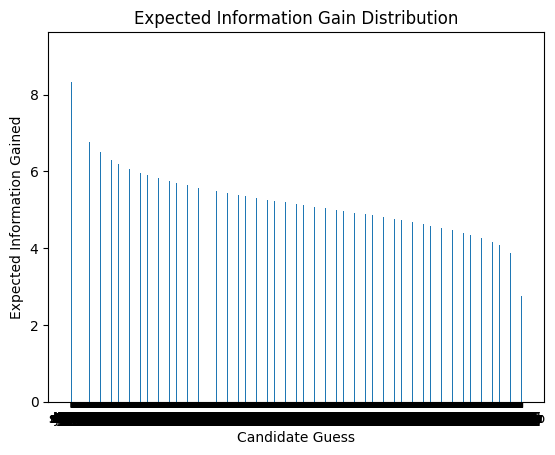

You are expected to gain 9.17292971563628 bits of information from your guess
⬛⬛⬛🟩⬛
[0.0, 0.0, 0.0, 1.0, 0.0]
You gained 3.598952516101983 bits of information with that guess
Guess eliminated 11884 words from the accepted word bank
Bot calculating


  0%|          | 0/1069 [00:00<?, ?it/s]

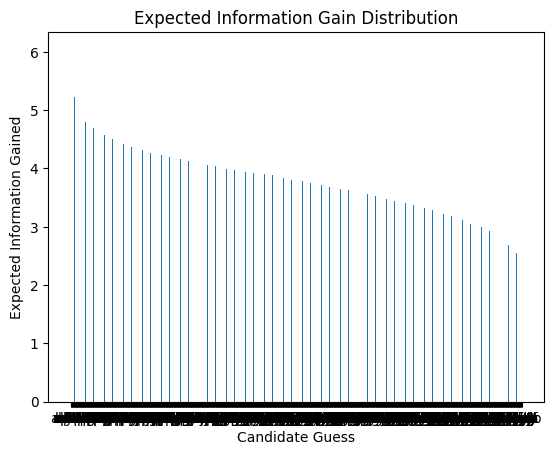

You are expected to gain 6.036841014035406 bits of information from your guess
⬛⬛⬛🟩⬛
[0.0, 0.0, 0.0, 1.0, 0.0]
You gained 1.410994446541562 bits of information with that guess
Guess eliminated 667 words from the accepted word bank
Bot calculating


  0%|          | 0/402 [00:00<?, ?it/s]

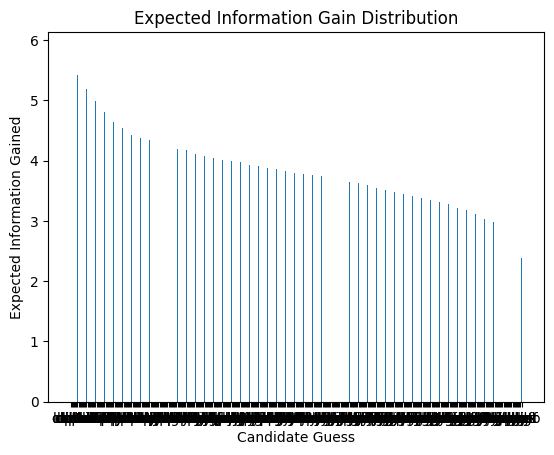

You are expected to gain 5.842822202456146 bits of information from your guess
⬛🟩⬛🟩⬛
[0.0, 1.0, 0.0, 1.0, 0.0]
You gained 3.0363418470637207 bits of information with that guess
Guess eliminated 353 words from the accepted word bank
Bot calculating


  0%|          | 0/49 [00:00<?, ?it/s]

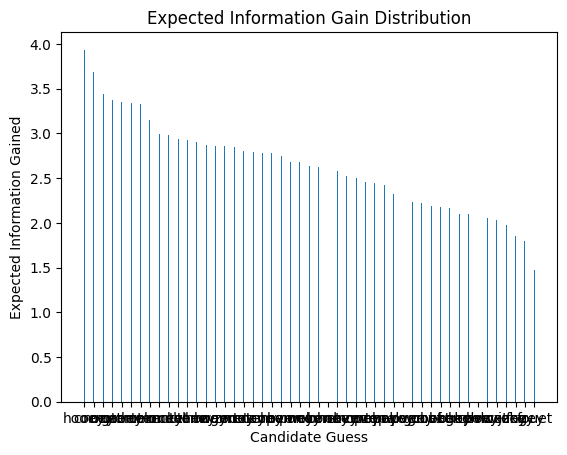

You are expected to gain 3.9349890450351386 bits of information from your guess
🟩🟩⬛🟩🟩
[1.0, 1.0, 0.0, 1.0, 1.0]
You gained 4.029747343394052 bits of information with that guess
Guess eliminated 46 words from the accepted word bank
Bot calculating


  0%|          | 0/3 [00:00<?, ?it/s]

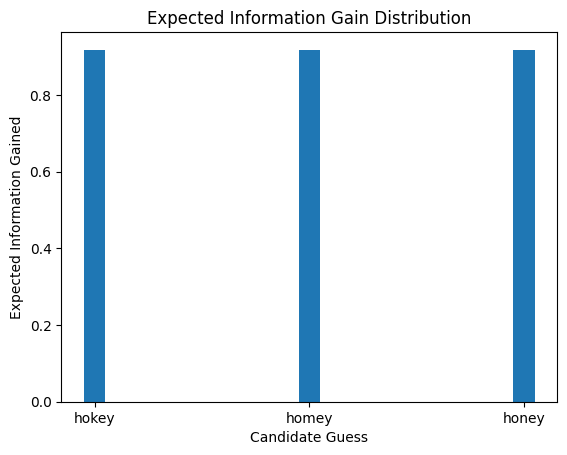

You are expected to gain 0.9182958340544896 bits of information from your guess
🟩🟩⬛🟩🟩
[1.0, 1.0, 0.0, 1.0, 1.0]
You gained 0.5849625007211563 bits of information with that guess
Guess eliminated 1 words from the accepted word bank


5

In [272]:
wordle_game("honey", True, 5, True)